# Train and save a model

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pickle
import shutil
from keras.preprocessing import image
from keras.models import save_model

### Configuration

In [2]:
batch_size = 10
img_height = 128
img_width = 128
data_dir = os.path.join(os.getcwd(), 'images', 'handsigns')
existing_data_dir = os.path.join(os.getcwd(), 'images', 'trainedImages')
testdata_dir = os.path.join(os.getcwd(), 'images', 'testimages')
class_names = None



### Images for training the model

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 4 classes.
Using 64 files for training.


### Images for validating the model

In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80 files belonging to 4 classes.
Using 16 files for validation.


### Images for testing the model

In [5]:
#test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  #testdata_dir,
  #image_size=(img_height, img_width),
  #batch_size=batch_size)

### Save classnames to text file using pickle dump

In [6]:
class_names = train_ds.class_names
print(class_names)
print(len(class_names))
f = open("classnames.txt", "wb")
f.write(pickle.dumps(class_names))
f.close()


['blackbox', 'blackbox_red', 'whitebox_black', 'whitebox_red']
4


### Read saved class names by using pickle

In [7]:
classnames = pickle.loads(open('classnames.txt', "rb").read())
print(classnames)

['blackbox', 'blackbox_red', 'whitebox_black', 'whitebox_red']


### Display pictures from trained dataset

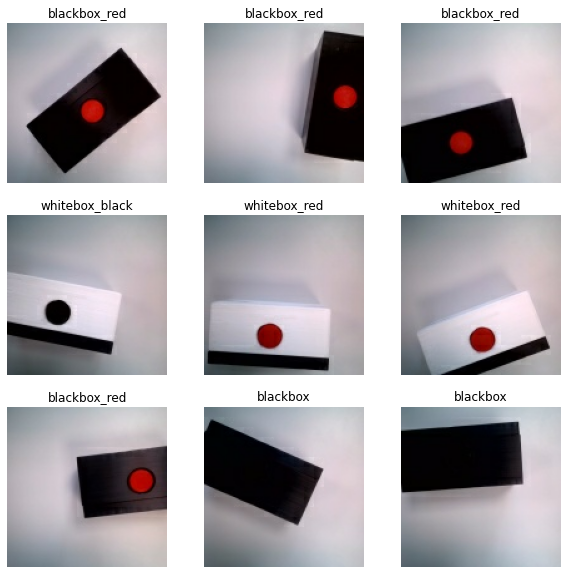

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Print info about tensors shape

In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 128, 128, 3)
(10,)


### Standardize the data

In [10]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.86666673


### Configure the dataset for performance

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train the model

### Augmentation

In [12]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)


Epoch 1/10
7/7 [==============================] - 3s 237ms/step - loss: 1.4160 - accuracy: 0.2344 - val_loss: 1.3801 - val_accuracy: 0.3125
Epoch 2/10
7/7 [==============================] - 1s 183ms/step - loss: 1.3628 - accuracy: 0.3750 - val_loss: 1.3519 - val_accuracy: 0.3750
Epoch 3/10
7/7 [==============================] - 1s 184ms/step - loss: 1.3138 - accuracy: 0.4375 - val_loss: 1.3010 - val_accuracy: 0.3750
Epoch 4/10
7/7 [==============================] - 1s 181ms/step - loss: 1.2186 - accuracy: 0.3906 - val_loss: 1.2248 - val_accuracy: 0.3125
Epoch 5/10
7/7 [==============================] - 1s 129ms/step - loss: 1.1442 - accuracy: 0.3125 - val_loss: 1.0574 - val_accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 1s 140ms/step - loss: 0.8667 - accuracy: 0.5625 - val_loss: 0.8864 - val_accuracy: 0.5000
Epoch 7/10
7/7 [==============================] - 1s 172ms/step - loss: 0.7035 - accuracy: 0.7188 - val_loss: 0.9068 - val_accuracy: 0.4375
Epoch 8/10
7/7 [====

### Test model accuracy with test pictures

In [14]:
#model.evaluate(test_ds)


In [15]:
### Visualize the testing for images in 'testimages' folder

blackbox 96.32 % ---- blackbox48d4c807-19eb-11ec-a2f6-98fa9b700496.jpg
blackbox_red 98.18 % ---- blackbox_red68ea6d85-19eb-11ec-a77e-98fa9b700496.jpg
whitebox_red 81.84 % ---- test.jpg
whitebox_black 78.89 % ---- whitebox_black30253f3d-19eb-11ec-89a5-98fa9b700496.jpg
whitebox_red 90.18 % ---- whitebox_red3f0e6229-19eb-11ec-a6a5-98fa9b700496.jpg


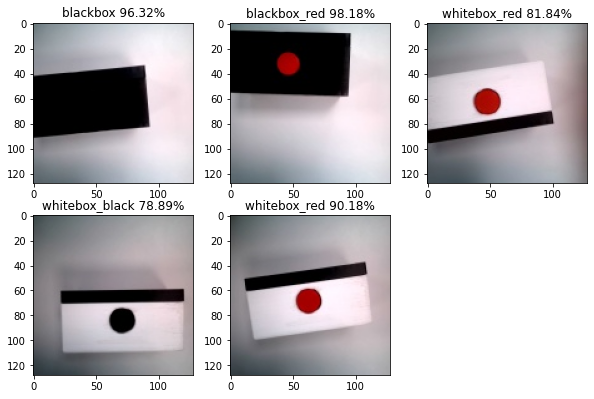

In [16]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
individual_pics_test_path = os.path.join(os.getcwd(), 'images', 'testimages')
pic_list = os.listdir(individual_pics_test_path)

plt.figure(figsize=(10, 10))

for count, picture in enumerate(pic_list):
    ax = plt.subplot(3, 3, count + 1)
    test_image_path = os.path.join(individual_pics_test_path, picture)
    test_image = image.load_img(test_image_path, (img_height,img_width))
    test_image = image.img_to_array(test_image)
    plt.imshow(test_image.astype("uint8"))
    test_image = np.expand_dims(test_image,axis=0)
    result = probability_model.predict(test_image)
    class_names[np.argmax(result)]
    plt.title(class_names[np.argmax(result)] + " " + str(round((np.amax(result)*100), 2)) + "%" )
    print(class_names[np.argmax(result)] + " " + str(round((np.amax(result)*100), 2)) + " % ---- " + picture)
    #training_set.class_indices




### 

### Save model

In [17]:
tf.keras.models.save_model(
  model, 'saved_model/mymodel')


INFO:tensorflow:Assets written to: saved_model/mymodel\assets


NameError: name 'existing_data' is not defined